In [3]:
cd ~/work/benchmark-join-suggestions/

/home/soda/rcappuzz/work/benchmark-join-suggestions


In [7]:
import datetime
import json
import logging
import pickle
from pathlib import Path

import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.metrics import mean_squared_error

import src.table_integration.join_profiling as jp
from src.candidate_discovery.utils_minhash import MinHashIndex
from src.data_preparation.utils import MetadataIndex
from src.utils.data_structures import CandidateJoin, RawDataset
from src.utils.pipeline_utils import generate_candidates

In [8]:
df = pl.read_csv("timestamps_indices.txt")

In [9]:
df = df.with_columns(
    pl.col("start").str.to_datetime(),
    pl.col("end").str.to_datetime(),
)

In [10]:
df.select(
    pl.col("version"),
    pl.col("end") - pl.col("start")
)

version,end
str,duration[μs]
"""binary""",3m 43s 442ms
"""wordnet""",5m 56s 784ms


# Study minhash indexing

In [13]:
#%%
index_dir = Path("data/metadata/_indices/testing_minhash/permutations")

query_dir = Path("data/metadata/queries")


#%%
index_dict = {}
for pth in index_dir.glob("**/*.pickle"):
    index_name = pth.stem
    index = MinHashIndex()
    index.load_index(pth)
    index_dict[index_name] = index


#%%
mdata_index = MetadataIndex(index_path="data/metadata/_mdi/md_index_full.pickle")

list_dict=[]
#%%
query_results = {}
for tab_path in query_dir.glob("*.json"):
    print(tab_path)
    mdata = json.load(open(tab_path))
    df = pl.read_parquet(mdata["full_path"])
    query = df["col_to_embed"].sample(int(3000)).drop_nulls()
    query_metadata = RawDataset(
        mdata["full_path"], "queries", "data/metadata/queries"
    )
    for index_name, index in index_dict.items():
        query_results[index_name] = index.query_index(query)
    candidates_by_index = {}

    for index, index_res in query_results.items():
        candidates = generate_candidates(
            index, index_res, mdata_index, query_metadata, "col_to_embed", 20
        )
        candidates_by_index[index] = candidates
    for index_name, candidates in candidates_by_index.items():
        for c, cand in candidates.items():
            src_md = cand.source_metadata
            cand_md = cand.candidate_metadata
            left_on = cand.left_on
            right_on = cand.right_on
            source_table = pl.read_parquet(src_md["full_path"])
            candidate_table = pl.read_parquet(cand_md["full_path"])
            containment=jp.measure_containment(source_table, candidate_table, left_on, right_on)
            c_dict = {
                "index_name": index_name,
                "source_table": src_md["full_path"],
                "candidate_table": cand_md["full_path"],
                "similarity": cand.similarity_score,
                "containment": containment
            }
            list_dict.append(c_dict)


# %%
results = pl.from_dicts(list_dict)
#%%
for g, group in results.groupby(["source_table", "index_name"]):
    print(g)
    
    print(mean_squared_error(group["containment"], group["similarity"], squared=False))


data/metadata/queries/afe785ccde50f3f1473fea96a39911c7.json
data/metadata/queries/2e605a4620c401d2c856693654adbbc2.json
data/metadata/queries/310b7e82655f2beaba69e8b482d43b65.json
('/storage/store/work/rcappuzz/ken_datasets/presidential-results/presidential-results-prepared.parquet', 'minhash_wordnet_64_index')
17.391382008495345
('/storage/store/work/rcappuzz/ken_datasets/company-employees/company-employees-prepared.parquet', 'minhash_binary_64_index')
19.85659255787171
('/storage/store/work/rcappuzz/ken_datasets/the-movies-dataset/movies-prepared.parquet', 'minhash_wordnet_256_index')
18.978701007890823
('/storage/store/work/rcappuzz/ken_datasets/the-movies-dataset/movies-prepared.parquet', 'minhash_binary_128_index')
18.319085781374426
('/storage/store/work/rcappuzz/ken_datasets/the-movies-dataset/movies-prepared.parquet', 'minhash_wordnet_128_index')
18.590281587601112
('/storage/store/work/rcappuzz/ken_datasets/presidential-results/presidential-results-prepared.parquet', 'minhash_

<Axes: xlabel='source_table', ylabel='difference'>

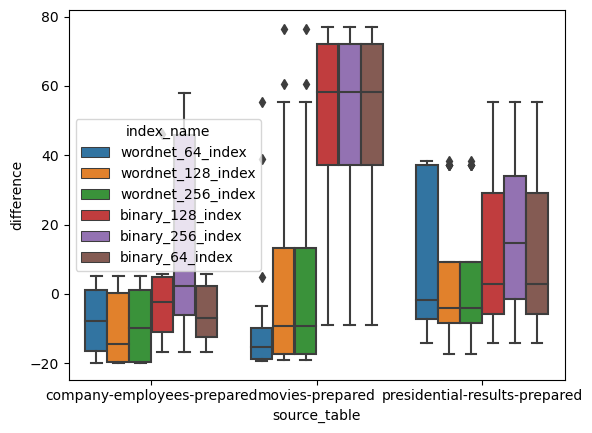

In [14]:

sub_results = results.with_columns(
    pl.col("source_table").apply(lambda x: Path(x).stem),
    pl.col("index_name").apply(lambda x: x.replace("minhash_", "")),
    pl.col("containment")*100,
    pl.col("similarity"),
    (pl.col("containment")*100 - pl.col("similarity")).alias("difference")
).sort(
    by=[
        "source_table", "difference"
    ]
).drop("candidate_table")
sns.boxplot(sub_results.to_pandas(), x="source_table", y="difference", hue="index_name")
